# TP : Data preparation

La préparation des données est une étape fondamentale dans le cycle du machine learning. Selon les experts d’IBM, le data cleaning représentent près de 80% du temps des analystes et autres data scientists ! Des erreurs durant ces étapes peuvent mener à des mauvaux fonctionnement ou de mauvaises performances très difficiles à déboguer.

## Import des librairies

In [1]:
import pandas as pd # Gestion des données
import seaborn as sns # outil de visualisation
import matplotlib.pyplot as plt # Librairie de visualisation
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler, maxabs_scale


In [2]:
# Import des librairies de métriques, encoding, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_percentage_error as mape

# Import des différents modèles de machine learning
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
import xgboost as xgb
import lightgbm as lgbm

## Partie 1 : Prédiction de survie sur la base de données Titanic


Pour cette partie, nous allons travailler sur les données de la base de données publique "Titanic", qui porte sur la survie des passagers de ce naufrage.

L'objectif est d'entrainer un modèle capable de prédire si un passager a survécu lors du naufrage à partir des attributs disponibles

Téléchargement des données

In [3]:
train_df = pd.read_csv("https://raw.githubusercontent.com/CharlesDampeyrou/titanic/master/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/CharlesDampeyrou/titanic/master/test.csv")
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
train_length = train_df.shape[0]

La librairie Pandas permet de traiter des données tabulaire. Lorsque les données sont importées dans un objet 'pandas.DataFrame', nous pouvons visualiser les n premières lignes de ce "DataFrame" à l'aide de la méthode "head(n)".

In [4]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Chaque ligne représente une entité de nos données, chaque colonne représente un attribut.
Les attributs ont les significations suivantes :
- passengerId : identifiant unique par passager
- Survived : 1 si le passager a survecu, 0 sinon
- Pclass : Classe du passager (1, 2 ou 3)
- Name : nom
- Sex : sexe du passager
- Age : Age du passager, ".5" signifie qu'il s'agit d'une estimation
- SibSp : nombre de frères et soeurs à bord
- Parch : nombre d'enfants et parents à bord
- Ticket : numéro du ticket
- Fare : prix payé
- Cabin : numéro de cabine
- Embarked : lieu d'embarquement (Cherbourg, Queenstown ou Southampton)

In [5]:
### QUESTION 1 : De la même manière, il existe une méthode pour afficher les
### dernière lignes d'un DataFrame. La trouver et aficher les 11 dernières
###  lignes.

# ... À COMPLÉTER

In [6]:
df.tail(11)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
1302,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q
1303,1304,NaN,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### Traitement des données problématiques

La méthode "duplicated()" permet de vérifier si une ligne a déjà été vue plus haut dans le DataFrame.

In [7]:
### QUESTION 2 : Vérifiez qu'il n'existe pas de doublons dans nos données.
# ... À COMPLÉTER
df = df.drop_duplicates()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Dans les pandas DataFrame, les données manquantes sont notées NaN (pour Not a Number). La méthode "isnull()" permet de vérifier si les données sont des NaN.

In [8]:
### QESTION 3 : Quelle est la proportion de données manquantes pour chacun des attributs ?
df.isnull().sum()/len(df)
# ... À COMPLÉTER

PassengerId    0.000000
Survived       0.319328
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.200917
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000764
Cabin          0.774637
Embarked       0.001528
dtype: float64

In [9]:
### QUESTION 4 : On peut remarquer qu'un attribut est particulièrement manquant, lequel ? Supprimer cette colonne.
df.drop('Cabin', axis=1, inplace=True)
df
# ... À COMPLÉTER

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S


L'attribut "Survived" comporte de nombreuses valeurs manquantes : il s'agit des valeurs pour le dataset de test.

In [10]:
### QUESTION 5 : Remplacer les valeurs manquantes pour l'age par l'age médian. On pourra s'intéresser à la méthode fillna.
df['Age'].fillna((df['Age'].mean()), inplace = True)
df['Age'].head(30)
# ... À COMPLÉTER

C:\Users\Bruno_Richard\AppData\Local\Temp\ipykernel_1204\1236407463.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna((df['Age'].mean()), inplace = True)


0     22.000000
1     38.000000
2     26.000000
3     35.000000
4     35.000000
5     29.881138
6     54.000000
7      2.000000
8     27.000000
9     14.000000
10     4.000000
11    58.000000
12    20.000000
13    39.000000
14    14.000000
15    55.000000
16     2.000000
17    29.881138
18    31.000000
19    29.881138
20    35.000000
21    34.000000
22    15.000000
23    28.000000
24     8.000000
25    38.000000
26    29.881138
27    19.000000
28    29.881138
29    29.881138
Name: Age, dtype: float64

In [11]:
df['Fare'].mean()

33.29547928134557

In [12]:
### Question 6 : Remplacer les valeur manquantes pour le prix du billet par le prix moyen.
df['Fare'].fillna(df['Fare'].mean(), inplace=True)
df['Fare'].head(30)

# ... À COMPLÉTER

C:\Users\Bruno_Richard\AppData\Local\Temp\ipykernel_1204\3234726815.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Fare'].fillna(df['Fare'].mean(), inplace=True)


0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
5       8.4583
6      51.8625
7      21.0750
8      11.1333
9      30.0708
10     16.7000
11     26.5500
12      8.0500
13     31.2750
14      7.8542
15     16.0000
16     29.1250
17     13.0000
18     18.0000
19      7.2250
20     26.0000
21     13.0000
22      8.0292
23     35.5000
24     21.0750
25     31.3875
26      7.2250
27    263.0000
28      7.8792
29      7.8958
Name: Fare, dtype: float64

In [13]:
### Question 7 : Remplacer les valeurs manquantes pour le lieu d'embarquement par le premier mode (valeur la plus fréquente).
df['Ticket'].fillna(df['Ticket'].mode(), inplace=True)
df
# ... À COMPLÉTER

C:\Users\Bruno_Richard\AppData\Local\Temp\ipykernel_1204\258545752.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Ticket'].fillna(df['Ticket'].mode(), inplace=True)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,29.881138,0,0,A.5. 3236,8.0500,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,29.881138,0,0,359309,8.0500,S


### Visualisation des données

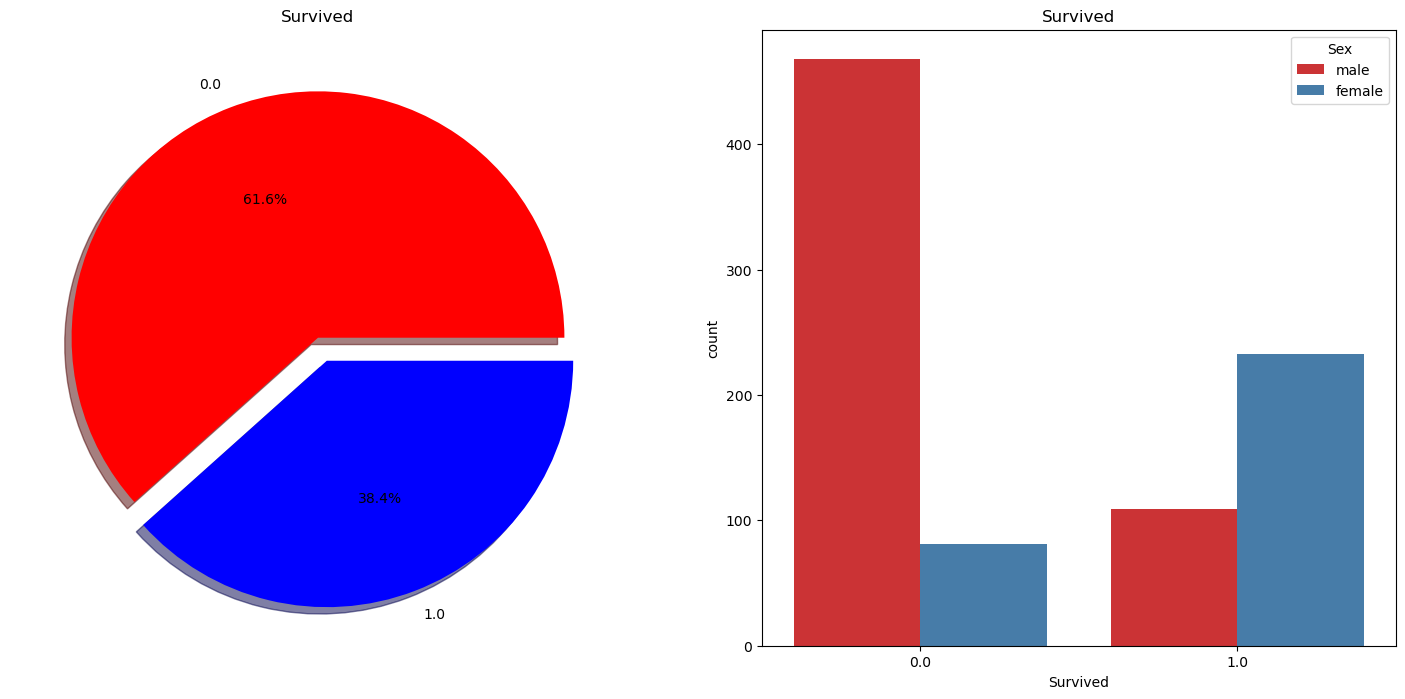

In [14]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0], colors = ['red', 'blue'],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x = 'Survived',data=df,ax=ax[1],palette="Set1", hue = "Sex")
ax[1].set_title('Survived')
plt.show()

On observe que la sexe est une variable très corrélée à la survie des passagers.

,Survived
Pclass,
1,136.0
2,87.0
3,119.0


C:\Users\Bruno_Richard\AppData\Local\Temp\ipykernel_1204\1270530119.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Pclass',data=df,ax=ax[0], palette = "icefire_r")


Text(0.5, 1.0, 'Pclass:Survived vs Dead')

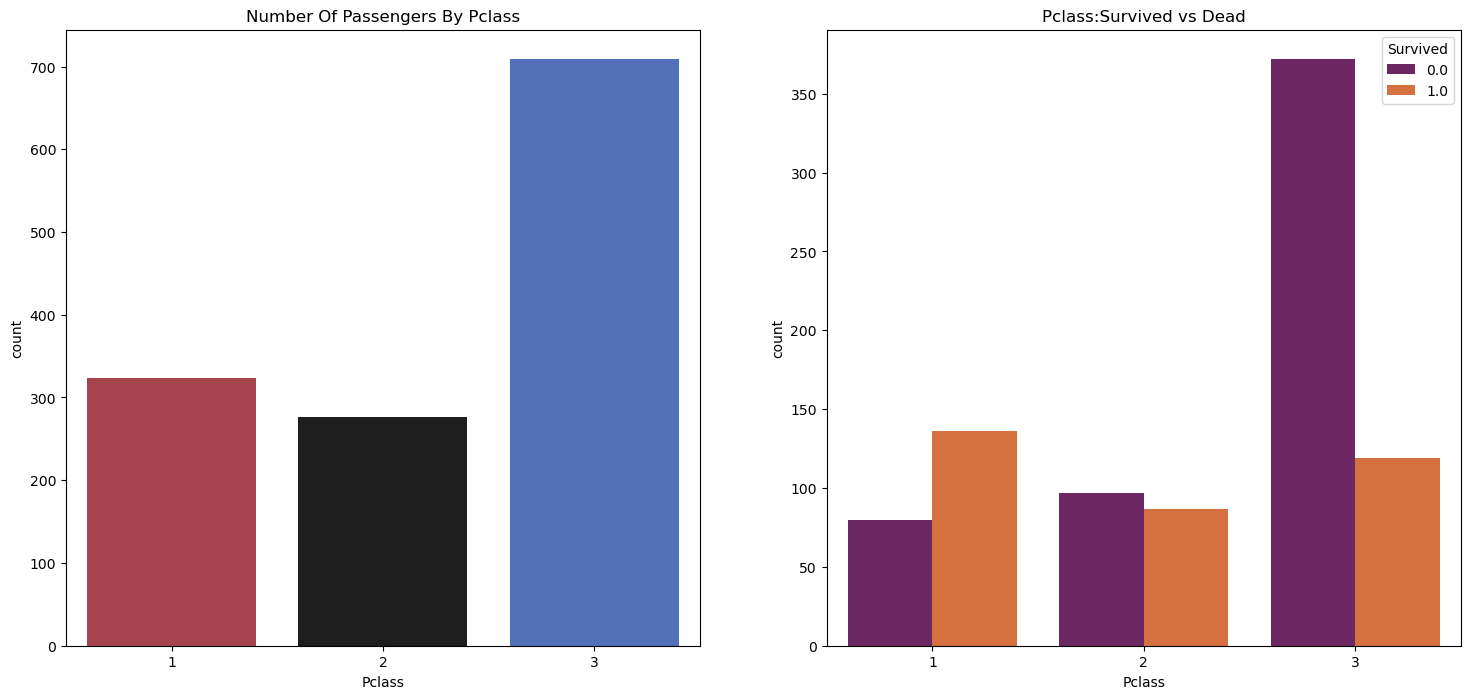

In [15]:
display(df.groupby("Pclass")[["Survived"]].sum())

f,ax=plt.subplots(1,2,figsize=(18,8))

sns.countplot(x='Pclass',data=df,ax=ax[0], palette = "icefire_r")
ax[0].set_title('Number Of Passengers By Pclass')

sns.countplot(x='Pclass',hue='Survived',data=df,ax=ax[1], palette = "inferno")
ax[1].set_title('Pclass:Survived vs Dead')


La classe ayant le plus de survivant est la classe 1, suivie par la 3ème classe puis la 2ème. Pourtant, la majorité des passagers étaient en 3ème classe. Plus le statut socio-économique des passagers était faible, plus grand était le risque qu'il ne survivent pas.

<Axes: xlabel='Sex,Survived'>

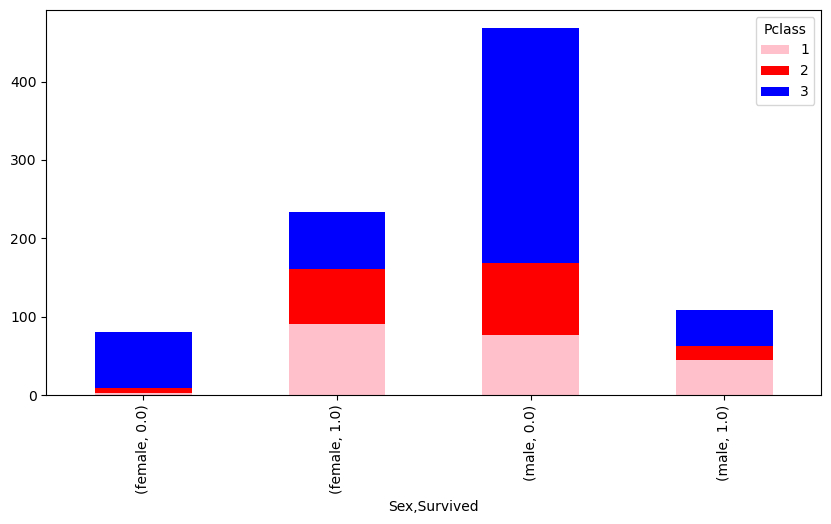

In [16]:
pd.crosstab([df.Sex,df.Survived],df.Pclass).plot.bar(stacked=True, color = ["pink","red", "blue"], figsize=(10,5))

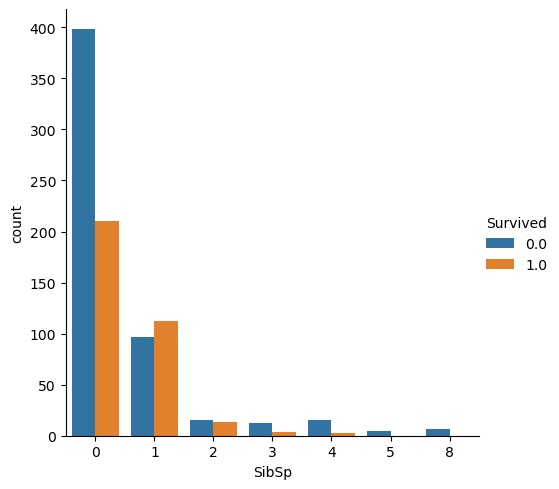

In [17]:
sns.catplot(data=df, x="SibSp", hue="Survived", kind="count" )

### Encodage des données




Tout d'abord, l'attribut "Sex" est constitué de 2 valeurs "male" et "female". Cet attribut peut être encodée de manière binaire.

La façon la plus rapide de réaliser cet encodage est d'utiliser des fonctions préexistantes. Le module preprocessing de la librairie sklearn permet de d'appliquer de nombreuses méthodes utiles en préprocessing. L'encodage de labels peut se faire de la manière suivante avec l'objet LabelEncoder du module preprocessing :
```python
lbe = LabelEncoder()
df["Sex"] = lbe.fit_transform(df["Sex"])
```
Nous n'allons cependant pas utiliser cette fonction afin de découvrir la méthode apply des DataFrames

In [18]:
### QUESTION 8 : Réaliser l'encodage de l'attribut "Sex" à l'aide de la méthode apply.

df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df

# ... À COMPLÉTER

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,29.881138,0,0,A.5. 3236,8.0500,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.000000,0,0,PC 17758,108.9000,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,NaN,3,"Ware, Mr. Frederick",1,29.881138,0,0,359309,8.0500,S


In [19]:
### QUESTION 9 : Lorsqu'un age est une estimation, 0.5 est ajouté à sa valeur.
### Par exemple, 22.5 signifie qu'on estime l'age de la personne à 22 ans. Créer
### un nouvel attribut "age_approximation" qui vaut 0 si l'age est connu, et 1
### si l'age est une approximation.

df['age_approximation'] = df['Age'].copy()*10
df['age_approximation'] = df['age_approximation'].apply(lambda x: 1  if (x % 5 == 0 and x % 2 != 0) else 0)
df[df['age_approximation'] == 1]

# ... À COMPLÉTER

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_approximation
57,58,0.0,3,"Novel, Mr. Mansouer",1,28.5,0,0,2697,7.229200,C,1
111,112,0.0,3,"Zabour, Miss. Hileni",0,14.5,1,0,2665,14.454200,C,1
116,117,0.0,3,"Connors, Mr. Patrick",1,70.5,0,0,370369,7.750000,Q,1
122,123,0.0,2,"Nasser, Mr. Nicholas",1,32.5,1,0,237736,30.070800,C,1
123,124,1.0,2,"Webber, Miss. Susan",0,32.5,0,0,27267,13.000000,S,1
148,149,0.0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",1,36.5,0,2,230080,26.000000,S,1
152,153,0.0,3,"Meo, Mr. Alfonzo",1,55.5,0,0,A.5. 11206,8.050000,S,1
153,154,0.0,3,"van Billiard, Mr. Austin Blyler",1,40.5,0,2,A/5. 851,14.500000,S,1
203,204,0.0,3,"Youseff, Mr. Gerious",1,45.5,0,0,2628,7.225000,C,1
227,228,0.0,3,"Lovell, Mr. John Hall (""Henry"")",1,20.5,0,0,A/5 21173,7.250000,S,1


In [20]:
### QUESTION 10 : Arrondir l'age à l'entier inférieur
df['Age'] = df['Age'].apply(np.floor) 
df
# ... À COMPLÉTER

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,age_approximation
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,29.0,0,0,A.5. 3236,8.0500,S,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.0,0,0,SOTON/O.Q. 3101262,7.2500,S,1
1307,1308,NaN,3,"Ware, Mr. Frederick",1,29.0,0,0,359309,8.0500,S,0


L'attribut "Embarked" présente 3 valeurs possibles, nous allons donc créer 3 nouveaux attributs "Embarked_C", "Embarked_Q" et "Embarked_S", qui prendront chacune la valeur 0 ou 1 selon le lieu d'embarquement du passager (fonction indicatrice).

QUESTION 11 : Comment s'appelle l'encodage que nous allons réaliser ?

*... À COMPLÉTER*

Nous pouvous remarquer que l'attribut "Embarked_C" peut être déduit des attributs "Embarked_Q" et "Embarked_S". Il n'est donc pas nécessaire de l'ajouter à notre DataFrame.

In [21]:
### QUESTION 12 : Se renseigner sur la fonction get_dummies de pandas. Réaliser
### l'encodage de "Embarked_Q" et "Embarked_S" à l'aide de cette fonction. On 
### pourra utiliser l'argument "drop_first=True" pour ne pas ajouter l'encodage
### de "Embarked_C".
df = pd.get_dummies(df, columns = ['Embarked'], drop_first = True)
df
# ... À COMPLÉTER

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,age_approximation,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,False,True
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0,False,True
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,29.0,0,0,A.5. 3236,8.0500,0,False,True
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,0,False,False
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.0,0,0,SOTON/O.Q. 3101262,7.2500,1,False,True
1307,1308,NaN,3,"Ware, Mr. Frederick",1,29.0,0,0,359309,8.0500,0,False,True


### Feature selection

Quelques attributs ne semblent pas avoir d'utilité, nous allons donc les supprimer. Le nom, le numéro de ticket et l'identifiant de passager ne nous apportent pas d'information, supprimons les.

In [22]:
### QUESTION 13 : Supprimer le nom, le numéro de ticket et l'identifiant de passager.
df.drop(['Name', 'Ticket', 'PassengerId'], axis = 1, inplace = True)
df

# ... À COMPLÉTER

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,age_approximation,Embarked_Q,Embarked_S
0,0.0,3,1,22.0,1,0,7.2500,0,False,True
1,1.0,1,0,38.0,1,0,71.2833,0,False,False
2,1.0,3,0,26.0,0,0,7.9250,0,False,True
3,1.0,1,0,35.0,1,0,53.1000,0,False,True
4,0.0,3,1,35.0,0,0,8.0500,0,False,True
...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,29.0,0,0,8.0500,0,False,True
1305,NaN,1,0,39.0,0,0,108.9000,0,False,False
1306,NaN,3,1,38.0,0,0,7.2500,1,False,True
1307,NaN,3,1,29.0,0,0,8.0500,0,False,True


### Division du dataset en un ensemble de données d'entrainement et un ensemble de données de test

In [23]:
train_length

df_train = df[:train_length]
df_test = df[train_length:]

Notre problème est un problème de classification à 2 classes portant sur l'attribut "Survived"

In [24]:
X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]

X_test = df_test.drop("Survived", axis=1)

### Normalisation

Une méthode rapide afin de normaliser des données est d'utiliser le StandardScaler du module sklearn.preprocessing. Nous allons cependant faire les calculs sans passer par cette fonction.

In [25]:
x = X_train

In [26]:
### QUESTION 14 : Normaliser les données X_train et X_test sans utiliser le StandardScaler
X_train['Pclass'] = (X_train['Pclass'] - X_train['Pclass'].min())/ (X_train['Pclass'].max() - X_train['Pclass'].min())
X_train['Age'] = (X_train['Age'] - X_train['Age'].min())/ (X_train['Age'].max() - X_train['Age'].min())
X_train['Fare'] = (X_train['Fare'] - X_train['Fare'].min())/ (X_train['Fare'].max() - X_train['Fare'].min())
X_train

X_test['Pclass'] = (X_test['Pclass'] - X_train['Pclass'].min())/ (X_train['Pclass'].max() - X_train['Pclass'].min())
X_test['Age'] = (X_test['Age'] - X_train['Age'].min())/ (X_train['Age'].max() - X_train['Age'].min())
X_test['Fare'] = (X_test['Fare'] - X_train['Fare'].min())/ (X_train['Fare'].max() - X_train['Fare'].min())
X_test

# ... À COMPLÉTER

,Pclass,Sex,Age,SibSp,Parch,Fare,age_approximation,Embarked_Q,Embarked_S
891,3.0,1,34.0,0,0,7.8292,1,True,False
892,3.0,0,47.0,1,0,7.0000,0,False,True
893,2.0,1,62.0,0,0,9.6875,0,True,False
894,3.0,1,27.0,0,0,8.6625,0,False,True
895,3.0,0,22.0,1,1,12.2875,0,False,True
...,...,...,...,...,...,...,...,...,...
1304,3.0,1,29.0,0,0,8.0500,0,False,True
1305,1.0,0,39.0,0,0,108.9000,0,False,False
1306,3.0,1,38.0,0,0,7.2500,1,False,True
1307,3.0,1,29.0,0,0,8.0500,0,False,True


In [27]:
# Autre solution :
x = X_train
xt = X_test
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
xt = scaler.transform(xt)

Autre solution :
```python
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
```

### Test de la précision avec plusieurs modèles

In [28]:
kfold = StratifiedKFold(n_splits=10)
random_state = 6

logistic_model = LogisticRegression(solver='lbfgs', max_iter=400,random_state=random_state)
knn_model = KNeighborsClassifier()
decision_model = DecisionTreeClassifier(random_state=random_state)
mlp_model = MLPClassifier(random_state=random_state)
gaussian_model = GaussianNB()
linear_svm_model = SVC(kernel='linear')
adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1)
randomforest_model = RandomForestClassifier(random_state=random_state)
extra_model = ExtraTreesClassifier(random_state=random_state)
gb_model = GradientBoostingClassifier(random_state=random_state)
xgb_model = xgb.XGBClassifier()
lgbm_model = lgbm.LGBMClassifier()

model_names = ["Logistic","Knn","DecisionTree","MLP","GaussianNB","SupportVectorMachine","AdaBoost","RandomForest","ExtraTrees","GradientBoost","Xgboost","Lightgbm"]
model_list = [logistic_model,decision_model,mlp_model,knn_model,gaussian_model,linear_svm_model,adaboost_model,randomforest_model,extra_model,gb_model,xgb_model,lgbm_model]
results = []
for i in model_list:
    result = cross_val_score(i, X_train, y_train, scoring = "accuracy", cv = kfold, n_jobs=4)
    results.append(result.mean())

acc_of_models = {"Model": model_names, "Mean Accuracy": results}    
acc_of_models = pd.DataFrame(acc_of_models)
acc_of_models

,Model,Mean Accuracy
0,Logistic,0.795755
1,Knn,0.778951
2,DecisionTree,0.794594
3,MLP,0.795768
4,GaussianNB,0.729538
5,SupportVectorMachine,0.787853
6,AdaBoost,0.774482
7,RandomForest,0.810387
8,ExtraTrees,0.803658
9,GradientBoost,0.829438


In [29]:
import sklearn
import xgboost
import lightgbm
import numpy

print("Scikit-Learn:", sklearn.__version__)
print("XGBoost:", xgboost.__version__)
print("LightGBM:", lightgbm.__version__)
print("NumPy:", numpy.__version__)

Scikit-Learn: 1.2.2
XGBoost: 2.1.3
LightGBM: 4.6.0
NumPy: 1.26.4


Réimportez les données dans un Dataframe, entrainez ces modèles sans data préparation, conclure sur l'influence de la préparation sur les performances des modèles.

In [30]:
### Import données
train_df = pd.read_csv("https://raw.githubusercontent.com/CharlesDampeyrou/titanic/master/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/CharlesDampeyrou/titanic/master/test.csv")
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
train_length = train_df.shape[0]

X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]
X_test = df_test.drop("Survived", axis=1)


### Test modèles
kfold = StratifiedKFold(n_splits=10)
random_state = 6

logistic_model = LogisticRegression(solver='lbfgs', max_iter=400,random_state=random_state)
knn_model = KNeighborsClassifier()
decision_model = DecisionTreeClassifier(random_state=random_state)
mlp_model = MLPClassifier(random_state=random_state)
gaussian_model = GaussianNB()
linear_svm_model = SVC(kernel='linear')
adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1)
randomforest_model = RandomForestClassifier(random_state=random_state)
extra_model = ExtraTreesClassifier(random_state=random_state)
gb_model = GradientBoostingClassifier(random_state=random_state)
xgb_model = xgb.XGBClassifier()
lgbm_model = lgbm.LGBMClassifier()

model_names = ["Logistic","Knn","DecisionTree","MLP","GaussianNB","SupportVectorMachine","AdaBoost","RandomForest","ExtraTrees","GradientBoost","Xgboost","Lightgbm"]
model_list = [logistic_model,decision_model,mlp_model,knn_model,gaussian_model,linear_svm_model,adaboost_model,randomforest_model,extra_model,gb_model,xgb_model,lgbm_model]
results = []
for i in model_list:
    result = cross_val_score(i, X_train, y_train, scoring = "accuracy", cv = kfold, n_jobs=4)
    results.append(result.mean())

acc_of_models = {"Model": model_names, "Mean Accuracy": results}    
acc_of_models = pd.DataFrame(acc_of_models)
acc_of_models

,Model,Mean Accuracy
0,Logistic,0.795755
1,Knn,0.780075
2,DecisionTree,0.679026
3,MLP,0.698190
4,GaussianNB,0.731785
5,SupportVectorMachine,0.787853
6,AdaBoost,0.777840
7,RandomForest,0.811511
8,ExtraTrees,0.803658
9,GradientBoost,0.829438


### Conclusion sur l'influence de la préparation sur les performances des différents modèles
La preparation augmenter le mean accuracy 
*À COMPLÉTER*

## Partie 2 : Prédiction de la consommation électrique française

L'objectif dans cette partie est de prédire la consommation electrique française.

### Chargement des données

In [31]:
df = pd.read_csv("https://raw.github.com/CharlesDampeyrou/titanic/master/RTE_with_exogene_features.csv")

In [32]:
df = df[['Datetime', 'Température (°C) | Auvergne-Rhône-Alpes',
       'Température (°C) | Bourgogne-Franche-Comté',
       'Température (°C) | Bretagne', 'Température (°C) | Centre-Val de Loire',
       'Température (°C) | Grand Est', 'Température (°C) | Hauts-de-France',
       'Température (°C) | Normandie', 'Température (°C) | Nouvelle-Aquitaine',
       'Température (°C) | Occitanie', 'Température (°C) | Pays de la Loire',
       "Température (°C) | Provence-Alpes-Côte d'Azur",
       'Température (°C) | Île-de-France',
       'Nebulosité totale (%) | Auvergne-Rhône-Alpes',
       'Nebulosité totale (%) | Bourgogne-Franche-Comté',
       'Nebulosité totale (%) | Bretagne',
       'Nebulosité totale (%) | Centre-Val de Loire',
       'Nebulosité totale (%) | Grand Est',
       'Nebulosité totale (%) | Hauts-de-France',
       'Nebulosité totale (%) | Normandie',
       'Nebulosité totale (%) | Nouvelle-Aquitaine',
       'Nebulosité totale (%) | Occitanie',
       'Nebulosité totale (%) | Pays de la Loire',
       "Nebulosité totale (%) | Provence-Alpes-Côte d'Azur",
       'Nebulosité totale (%) | Île-de-France',
       'Consommation (MW) | Auvergne-Rhône-Alpes',
       'Consommation (MW) | Bourgogne-Franche-Comté',
       'Consommation (MW) | Bretagne',
       'Consommation (MW) | Centre-Val de Loire',
       'Consommation (MW) | Grand Est', 'Consommation (MW) | Hauts-de-France',
       'Consommation (MW) | Normandie',
       'Consommation (MW) | Nouvelle-Aquitaine',
       'Consommation (MW) | Occitanie', 'Consommation (MW) | Pays de la Loire',
       "Consommation (MW) | Provence-Alpes-Côte d'Azur",
       'Consommation (MW) | Île-de-France',
       'Vacances scolaires | Bourgogne-Franche-Comté',
       'Vacances scolaires | Bretagne',
       'Vacances scolaires | Centre-Val de Loire',
       'Vacances scolaires | Grand Est',
       'Vacances scolaires | Hauts-de-France',
       'Vacances scolaires | Île-de-France', 'Vacances scolaires | Normandie',
       'Vacances scolaires | Nouvelle-Aquitaine',
       'Vacances scolaires | Occitanie',
       'Vacances scolaires | Pays de la Loire',
       "Vacances scolaires | Provence-Alpes-Côte d'Azur",
       'Vacances scolaires | Auvergne-Rhône-Alpes', 
       'Jour férié',]]

In [33]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.set_index("Datetime", inplace=True)
df["Datetime"] = df.index

<Axes: xlabel='Datetime'>

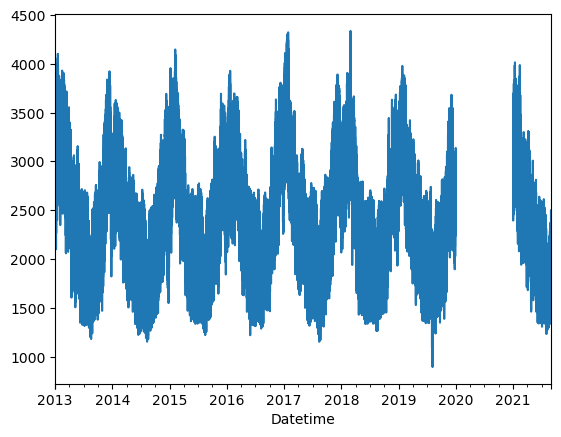

In [34]:
df['Consommation (MW) | Bourgogne-Franche-Comté'].plot()

On observe qu'il manque les données pour l'année 2020, nous allons donc travailler sur la période 2013-2019.

In [35]:
df = df["2013":"2019"]

### Visualisation des données

In [36]:
pd.options.plotting.backend = "matplotlib"

In [37]:
def get_regions(): # N'hésitez pas à réutiliser cette fonction.
    return ([
            "Bourgogne-Franche-Comté",
            "Bretagne",
            "Centre-Val de Loire",
            "Grand Est",
            "Hauts-de-France",
            "Île-de-France",
            "Normandie",
            "Nouvelle-Aquitaine",
            "Occitanie",
            "Pays de la Loire",
            "Provence-Alpes-Côte d'Azur",
            "Auvergne-Rhône-Alpes",
        ])

In [38]:
list(df)

['Température (°C) | Auvergne-Rhône-Alpes',
 'Température (°C) | Bourgogne-Franche-Comté',
 'Température (°C) | Bretagne',
 'Température (°C) | Centre-Val de Loire',
 'Température (°C) | Grand Est',
 'Température (°C) | Hauts-de-France',
 'Température (°C) | Normandie',
 'Température (°C) | Nouvelle-Aquitaine',
 'Température (°C) | Occitanie',
 'Température (°C) | Pays de la Loire',
 "Température (°C) | Provence-Alpes-Côte d'Azur",
 'Température (°C) | Île-de-France',
 'Nebulosité totale (%) | Auvergne-Rhône-Alpes',
 'Nebulosité totale (%) | Bourgogne-Franche-Comté',
 'Nebulosité totale (%) | Bretagne',
 'Nebulosité totale (%) | Centre-Val de Loire',
 'Nebulosité totale (%) | Grand Est',
 'Nebulosité totale (%) | Hauts-de-France',
 'Nebulosité totale (%) | Normandie',
 'Nebulosité totale (%) | Nouvelle-Aquitaine',
 'Nebulosité totale (%) | Occitanie',
 'Nebulosité totale (%) | Pays de la Loire',
 "Nebulosité totale (%) | Provence-Alpes-Côte d'Azur",
 'Nebulosité totale (%) | Île-de-Fra

In [39]:
### QUESTION 15 : Créer une colonne "Consommation France (MW)" qui comporte la
### somme des consommations de toutes les régions
df['Consommation_France_(MW)'] =  df['Consommation (MW) | Auvergne-Rhône-Alpes'].iloc[:] + df['Consommation (MW) | Bourgogne-Franche-Comté'].iloc[:] + df['Consommation (MW) | Bretagne'].iloc[:] +df['Consommation (MW) | Centre-Val de Loire'].iloc[:] +df['Consommation (MW) | Grand Est'].iloc[:] + df['Consommation (MW) | Hauts-de-France'].iloc[:] +df['Consommation (MW) | Normandie'].iloc[:] + df['Consommation (MW) | Nouvelle-Aquitaine'].iloc[:] + df['Consommation (MW) | Occitanie'].iloc[:] +df['Consommation (MW) | Pays de la Loire'].iloc[:] + df["Consommation (MW) | Provence-Alpes-Côte d'Azur"].iloc[:] + df['Consommation (MW) | Île-de-France'].iloc[:]
df
# ... À COMPLÉTER

,Température (°C) | Auvergne-Rhône-Alpes,Température (°C) | Bourgogne-Franche-Comté,Température (°C) | Bretagne,Température (°C) | Centre-Val de Loire,Température (°C) | Grand Est,Température (°C) | Hauts-de-France,Température (°C) | Normandie,Température (°C) | Nouvelle-Aquitaine,Température (°C) | Occitanie,Température (°C) | Pays de la Loire,...,Vacances scolaires | Île-de-France,Vacances scolaires | Normandie,Vacances scolaires | Nouvelle-Aquitaine,Vacances scolaires | Occitanie,Vacances scolaires | Pays de la Loire,Vacances scolaires | Provence-Alpes-Côte d'Azur,Vacances scolaires | Auvergne-Rhône-Alpes,Jour férié,Datetime,Consommation_France_(MW)
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,7.375000,2.700000,9.775000,7.800000,5.040000,8.400000,8.950000,8.520000,6.085714,9.800000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 00:00:00+00:00,57806.5
2013-01-01 01:00:00+00:00,7.458333,3.533333,9.441667,7.916667,5.080000,8.316667,8.900000,8.640000,6.114286,9.666667,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 01:00:00+00:00,56941.5
2013-01-01 02:00:00+00:00,7.541667,4.366667,9.108333,8.033333,5.120000,8.233333,8.850000,8.760000,6.142857,9.533333,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 02:00:00+00:00,53497.0
2013-01-01 03:00:00+00:00,7.625000,5.200000,8.775000,8.150000,5.160000,8.150000,8.800000,8.880000,6.171429,9.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 03:00:00+00:00,50318.5
2013-01-01 04:00:00+00:00,7.575000,5.466667,8.600000,8.233333,5.220000,8.250000,8.633333,8.846667,6.195238,9.133333,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 04:00:00+00:00,49022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,1.958333,-0.066667,8.491667,1.983333,-0.386667,2.250000,2.591667,7.293333,6.457143,7.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 19:00:00+00:00,66747.0
2019-12-31 20:00:00+00:00,1.391667,-0.133333,8.533333,1.966667,-0.713333,1.900000,2.558333,7.126667,6.085714,7.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 20:00:00+00:00,63950.0
2019-12-31 21:00:00+00:00,0.825000,-0.200000,8.575000,1.950000,-1.040000,1.550000,2.525000,6.960000,5.714286,7.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 21:00:00+00:00,63215.5


<Axes: xlabel='Datetime'>

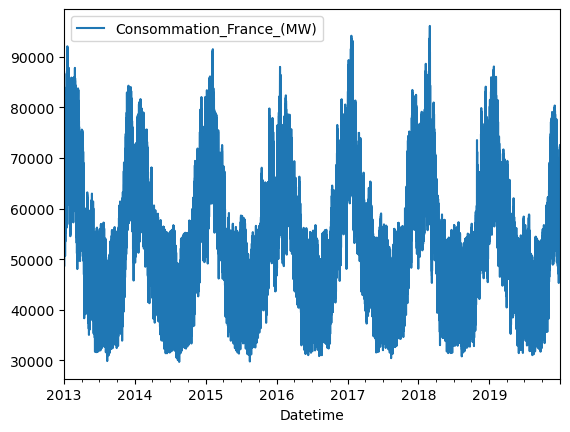

In [40]:
df[["Consommation_France_(MW)", "Datetime"]].plot(x="Datetime", y="Consommation_France_(MW)")

QUESTION 16 : On observe une anomalie touts les ans, une idée sur son origine?

QUESTION 17 : Regarder le graphe à plusieurs échelles. Citer des attributs temporels qui semblent avoir de l'importance.

### Traitement des données manquantes

In [41]:
### QUESTION 18 : Afficher le nombre de données manquantes dans le DataFrame en
### fonction des attributs. Il s'agit des anomalies détectées question 14
len(df.isnull().sum())
# à compléter

51

In [42]:
df.isnull().sum()

Température (°C) | Auvergne-Rhône-Alpes               0
Température (°C) | Bourgogne-Franche-Comté            0
Température (°C) | Bretagne                           0
Température (°C) | Centre-Val de Loire                0
Température (°C) | Grand Est                          0
Température (°C) | Hauts-de-France                    0
Température (°C) | Normandie                          0
Température (°C) | Nouvelle-Aquitaine                 0
Température (°C) | Occitanie                          0
Température (°C) | Pays de la Loire                   0
Température (°C) | Provence-Alpes-Côte d'Azur         0
Température (°C) | Île-de-France                      0
Nebulosité totale (%) | Auvergne-Rhône-Alpes          0
Nebulosité totale (%) | Bourgogne-Franche-Comté       0
Nebulosité totale (%) | Bretagne                      0
Nebulosité totale (%) | Centre-Val de Loire           0
Nebulosité totale (%) | Grand Est                     0
Nebulosité totale (%) | Hauts-de-France         

In [43]:
### Question 19 : Le nombre de valeurs manquantes est faible, les remplacer par 
### une interpolation linéaire. Calculer à nouveau la consommation totale pour
### prendre en compte les modifications`
df.interpolate(method='linear', inplace=True)
# À COMPLÉTER

In [44]:
df['Consommation_France_(MW)'] =  df['Consommation (MW) | Auvergne-Rhône-Alpes'].iloc[:] + df['Consommation (MW) | Bourgogne-Franche-Comté'].iloc[:] + df['Consommation (MW) | Bretagne'].iloc[:] +df['Consommation (MW) | Centre-Val de Loire'].iloc[:] +df['Consommation (MW) | Grand Est'].iloc[:] + df['Consommation (MW) | Hauts-de-France'].iloc[:] +df['Consommation (MW) | Normandie'].iloc[:] + df['Consommation (MW) | Nouvelle-Aquitaine'].iloc[:] + df['Consommation (MW) | Occitanie'].iloc[:] +df['Consommation (MW) | Pays de la Loire'].iloc[:] + df["Consommation (MW) | Provence-Alpes-Côte d'Azur"].iloc[:] + df['Consommation (MW) | Île-de-France'].iloc[:]
df

,Température (°C) | Auvergne-Rhône-Alpes,Température (°C) | Bourgogne-Franche-Comté,Température (°C) | Bretagne,Température (°C) | Centre-Val de Loire,Température (°C) | Grand Est,Température (°C) | Hauts-de-France,Température (°C) | Normandie,Température (°C) | Nouvelle-Aquitaine,Température (°C) | Occitanie,Température (°C) | Pays de la Loire,...,Vacances scolaires | Île-de-France,Vacances scolaires | Normandie,Vacances scolaires | Nouvelle-Aquitaine,Vacances scolaires | Occitanie,Vacances scolaires | Pays de la Loire,Vacances scolaires | Provence-Alpes-Côte d'Azur,Vacances scolaires | Auvergne-Rhône-Alpes,Jour férié,Datetime,Consommation_France_(MW)
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,7.375000,2.700000,9.775000,7.800000,5.040000,8.400000,8.950000,8.520000,6.085714,9.800000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 00:00:00+00:00,57806.5
2013-01-01 01:00:00+00:00,7.458333,3.533333,9.441667,7.916667,5.080000,8.316667,8.900000,8.640000,6.114286,9.666667,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 01:00:00+00:00,56941.5
2013-01-01 02:00:00+00:00,7.541667,4.366667,9.108333,8.033333,5.120000,8.233333,8.850000,8.760000,6.142857,9.533333,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 02:00:00+00:00,53497.0
2013-01-01 03:00:00+00:00,7.625000,5.200000,8.775000,8.150000,5.160000,8.150000,8.800000,8.880000,6.171429,9.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 03:00:00+00:00,50318.5
2013-01-01 04:00:00+00:00,7.575000,5.466667,8.600000,8.233333,5.220000,8.250000,8.633333,8.846667,6.195238,9.133333,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 04:00:00+00:00,49022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,1.958333,-0.066667,8.491667,1.983333,-0.386667,2.250000,2.591667,7.293333,6.457143,7.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 19:00:00+00:00,66747.0
2019-12-31 20:00:00+00:00,1.391667,-0.133333,8.533333,1.966667,-0.713333,1.900000,2.558333,7.126667,6.085714,7.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 20:00:00+00:00,63950.0
2019-12-31 21:00:00+00:00,0.825000,-0.200000,8.575000,1.950000,-1.040000,1.550000,2.525000,6.960000,5.714286,7.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 21:00:00+00:00,63215.5


### Encodage des données

In [45]:
### QUESTION 20 : Créer des attributs "hour_sin" et "hour_cos" qui comportent 
### l'heure du jour après une transformation par les fonctions cosinus et sinus.
hour_sin = []
hour_cos = []
for date in df['Datetime']:
    hour_sin.append(np.sin((2*(math.pi)*date.hour)/len(df['Datetime'])))
    hour_cos.append(np.cos((2*(math.pi)*date.hour)/len(df['Datetime'])))
df['hour_sin'] = hour_sin
df['hour_cos'] = hour_cos
df
# À COMPLÉTER

,Température (°C) | Auvergne-Rhône-Alpes,Température (°C) | Bourgogne-Franche-Comté,Température (°C) | Bretagne,Température (°C) | Centre-Val de Loire,Température (°C) | Grand Est,Température (°C) | Hauts-de-France,Température (°C) | Normandie,Température (°C) | Nouvelle-Aquitaine,Température (°C) | Occitanie,Température (°C) | Pays de la Loire,...,Vacances scolaires | Nouvelle-Aquitaine,Vacances scolaires | Occitanie,Vacances scolaires | Pays de la Loire,Vacances scolaires | Provence-Alpes-Côte d'Azur,Vacances scolaires | Auvergne-Rhône-Alpes,Jour férié,Datetime,Consommation_France_(MW),hour_sin,hour_cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,7.375000,2.700000,9.775000,7.800000,5.040000,8.400000,8.950000,8.520000,6.085714,9.800000,...,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 00:00:00+00:00,57806.5,0.000000,1.000000
2013-01-01 01:00:00+00:00,7.458333,3.533333,9.441667,7.916667,5.080000,8.316667,8.900000,8.640000,6.114286,9.666667,...,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 01:00:00+00:00,56941.5,0.000102,1.000000
2013-01-01 02:00:00+00:00,7.541667,4.366667,9.108333,8.033333,5.120000,8.233333,8.850000,8.760000,6.142857,9.533333,...,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 02:00:00+00:00,53497.0,0.000205,1.000000
2013-01-01 03:00:00+00:00,7.625000,5.200000,8.775000,8.150000,5.160000,8.150000,8.800000,8.880000,6.171429,9.400000,...,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 03:00:00+00:00,50318.5,0.000307,1.000000
2013-01-01 04:00:00+00:00,7.575000,5.466667,8.600000,8.233333,5.220000,8.250000,8.633333,8.846667,6.195238,9.133333,...,1.0,1.0,1.0,1.0,1.0,1.0,2013-01-01 04:00:00+00:00,49022.0,0.000410,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,1.958333,-0.066667,8.491667,1.983333,-0.386667,2.250000,2.591667,7.293333,6.457143,7.400000,...,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 19:00:00+00:00,66747.0,0.001946,0.999998
2019-12-31 20:00:00+00:00,1.391667,-0.133333,8.533333,1.966667,-0.713333,1.900000,2.558333,7.126667,6.085714,7.400000,...,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 20:00:00+00:00,63950.0,0.002049,0.999998
2019-12-31 21:00:00+00:00,0.825000,-0.200000,8.575000,1.950000,-1.040000,1.550000,2.525000,6.960000,5.714286,7.400000,...,1.0,1.0,1.0,1.0,1.0,0.0,2019-12-31 21:00:00+00:00,63215.5,0.002151,0.999998


In [46]:
### QUESTION 21 : De même, créer les attributs "weekday_cos", "weekday_sin",
### "week_cos" et "week_sin"
weekday_sin = []
weekday_cos = []
week_cos = []
week_sin = []
for date in df['Datetime']:
    weekday_sin.append(np.sin((2*(math.pi)*date.day)/len(df['Datetime'])))
    weekday_cos.append(np.cos((2*(math.pi)*date.day)/len(df['Datetime'])))
    week_cos.append(np.cos((2*(math.pi)*date.week)/len(df['Datetime'])))
    week_sin.append(np.sin((2*(math.pi)*date.week)/len(df['Datetime'])))
df['weekday_sin'] = weekday_sin
df['weekday_cos'] = weekday_cos
df['week_cos'] = week_cos
df['week_sin'] = week_sin
df
# À COMPLÉTER

,Température (°C) | Auvergne-Rhône-Alpes,Température (°C) | Bourgogne-Franche-Comté,Température (°C) | Bretagne,Température (°C) | Centre-Val de Loire,Température (°C) | Grand Est,Température (°C) | Hauts-de-France,Température (°C) | Normandie,Température (°C) | Nouvelle-Aquitaine,Température (°C) | Occitanie,Température (°C) | Pays de la Loire,...,Vacances scolaires | Auvergne-Rhône-Alpes,Jour férié,Datetime,Consommation_France_(MW),hour_sin,hour_cos,weekday_sin,weekday_cos,week_cos,week_sin
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,7.375000,2.700000,9.775000,7.800000,5.040000,8.400000,8.950000,8.520000,6.085714,9.800000,...,1.0,1.0,2013-01-01 00:00:00+00:00,57806.5,0.000000,1.000000,0.000102,1.000000,1.0,0.000102
2013-01-01 01:00:00+00:00,7.458333,3.533333,9.441667,7.916667,5.080000,8.316667,8.900000,8.640000,6.114286,9.666667,...,1.0,1.0,2013-01-01 01:00:00+00:00,56941.5,0.000102,1.000000,0.000102,1.000000,1.0,0.000102
2013-01-01 02:00:00+00:00,7.541667,4.366667,9.108333,8.033333,5.120000,8.233333,8.850000,8.760000,6.142857,9.533333,...,1.0,1.0,2013-01-01 02:00:00+00:00,53497.0,0.000205,1.000000,0.000102,1.000000,1.0,0.000102
2013-01-01 03:00:00+00:00,7.625000,5.200000,8.775000,8.150000,5.160000,8.150000,8.800000,8.880000,6.171429,9.400000,...,1.0,1.0,2013-01-01 03:00:00+00:00,50318.5,0.000307,1.000000,0.000102,1.000000,1.0,0.000102
2013-01-01 04:00:00+00:00,7.575000,5.466667,8.600000,8.233333,5.220000,8.250000,8.633333,8.846667,6.195238,9.133333,...,1.0,1.0,2013-01-01 04:00:00+00:00,49022.0,0.000410,1.000000,0.000102,1.000000,1.0,0.000102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,1.958333,-0.066667,8.491667,1.983333,-0.386667,2.250000,2.591667,7.293333,6.457143,7.400000,...,1.0,0.0,2019-12-31 19:00:00+00:00,66747.0,0.001946,0.999998,0.003175,0.999995,1.0,0.000102
2019-12-31 20:00:00+00:00,1.391667,-0.133333,8.533333,1.966667,-0.713333,1.900000,2.558333,7.126667,6.085714,7.400000,...,1.0,0.0,2019-12-31 20:00:00+00:00,63950.0,0.002049,0.999998,0.003175,0.999995,1.0,0.000102
2019-12-31 21:00:00+00:00,0.825000,-0.200000,8.575000,1.950000,-1.040000,1.550000,2.525000,6.960000,5.714286,7.400000,...,1.0,0.0,2019-12-31 21:00:00+00:00,63215.5,0.002151,0.999998,0.003175,0.999995,1.0,0.000102


### Sélection des features

In [47]:
### QUESTION 22 : Créer un dataframe X comportant la température, la nébulosité,
### l'heure (en encodage cos et sin), le jour de la semaine (en encodage cos et
### sin), la semaine de l'année (en encodage cos et sin), les vacances scolaires
###  et la variable jour férié. Créer un dataframe y comportant la consommation
### totale française.
df_X = df[['Datetime','Température (°C) | Auvergne-Rhône-Alpes',
       'Température (°C) | Bourgogne-Franche-Comté',
       'Température (°C) | Bretagne', 'Température (°C) | Centre-Val de Loire',
       'Température (°C) | Grand Est', 'Température (°C) | Hauts-de-France',
       'Température (°C) | Normandie', 'Température (°C) | Nouvelle-Aquitaine',
       'Température (°C) | Occitanie', 'Température (°C) | Pays de la Loire',
       "Température (°C) | Provence-Alpes-Côte d'Azur",
       'Température (°C) | Île-de-France',
       'Nebulosité totale (%) | Auvergne-Rhône-Alpes',
       'Nebulosité totale (%) | Bourgogne-Franche-Comté',
       'Nebulosité totale (%) | Bretagne',
       'Nebulosité totale (%) | Centre-Val de Loire',
       'Nebulosité totale (%) | Grand Est',
       'Nebulosité totale (%) | Hauts-de-France',
       'Nebulosité totale (%) | Normandie',
       'Nebulosité totale (%) | Nouvelle-Aquitaine',
       'Nebulosité totale (%) | Occitanie',
       'Nebulosité totale (%) | Pays de la Loire',
       "Nebulosité totale (%) | Provence-Alpes-Côte d'Azur",
       'Nebulosité totale (%) | Île-de-France',
       'Vacances scolaires | Bourgogne-Franche-Comté',
       'Vacances scolaires | Bretagne',
       'Vacances scolaires | Centre-Val de Loire',
       'Vacances scolaires | Grand Est',
       'Vacances scolaires | Hauts-de-France',
       'Vacances scolaires | Île-de-France', 'Vacances scolaires | Normandie',
       'Vacances scolaires | Nouvelle-Aquitaine',
       'Vacances scolaires | Occitanie',
       'Vacances scolaires | Pays de la Loire',
       "Vacances scolaires | Provence-Alpes-Côte d'Azur",
       'Vacances scolaires | Auvergne-Rhône-Alpes', 'Consommation_France_(MW)',
       'Jour férié','weekday_sin','weekday_cos','week_cos','week_sin']]
# À COMPLÉTER

### Séparation train / test

In [48]:
### QUESTION 23 : Séparer les données en un ensemble d'entrainement (années 2013
### à 2017) et un ensemble de test (2018 et 2019)
df_train = df_X["2013":"2017"]
df_test = df_X["2018":"2019"]
X_train = df_train.drop(['Consommation_France_(MW)', 'Datetime'], axis=1)
Y_train = df_train['Consommation_France_(MW)']
X_test = df_test.drop(['Consommation_France_(MW)', 'Datetime'], axis=1)
Y_test = df_test['Consommation_France_(MW)']
# À COMPLÉTER

### Normalisation des données

Afin de pouvoir calculer la MAPE (mean absolute percentage error) sans devoir dénormaliser les données, nous allons faire une normalisation "MaxAbs" pour y, c'est à dire diviser les données par le maximum de la valeur absolue.

In [49]:
### QUESTION 24 : centrer et réduire X_train et X_test
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# À COMPLÉTER

In [50]:
### QUESTION 25 : Faire une normalisation maxabs sur y_train et y_test

from sklearn.preprocessing import MaxAbsScaler
maxabs_scaler = MaxAbsScaler()
Y_train = maxabs_scaler.fit_transform(Y_train.values.reshape(-1, 1))
Y_test = maxabs_scaler.transform(Y_test.values.reshape(-1, 1)) 

# À COMPLÉTER

### Entrainement et évaluation de performences

In [51]:
Y_train = Y_train.ravel()
model = MLPRegressor()
model.fit(X_train, Y_train)

MLPRegressor()

In [53]:
Y_pred = model.predict(X_test)
error = mape(Y_test, Y_pred)
print(f"Erreur moyenne : {error}%")

Erreur moyenne : 0.10066748964253547%


Question 26 : Ajouter la température moyenne sur les dernières 24h et observer la différence de performances.

Conclure sur l'intérêt de ce nouvel attribut et sur l'importance 